In [1]:
# All utilitaries are in this module
import sys
sys.path.append('../')
from reproduction.mimno_embeddings import *

# Pre-Step : Information about the corpus

On évalue rapidement le corpus et on en obtient des informations pour mettre en regard certaines distributions.

In [2]:
import collections
import numpy as np 
import json
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def read_corpus(path=None):
    """ Read the corpus """
    if not path:
        path = fixed_order()
    for file in path:
        with open(file) as f:
            yield from f.read().split()

distribution = collections.Counter(read_corpus())
total_words = sum(distribution.values())


## Plotting word distribution

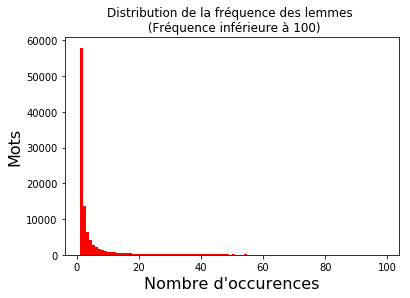

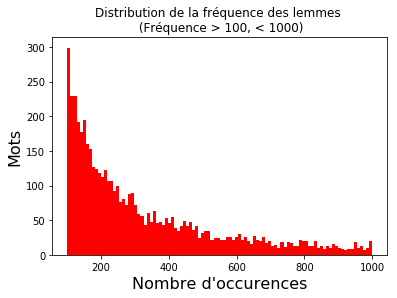

96716 lemmes apparaissent moins de 20 fois, 104319 apparaissent moins de 100, tandis que 6407 apparaissent plus de 100 fois


In [3]:
distribution_array = np.array(list(distribution.values()))
count, bins, ignored = plt.hist(
    distribution_array[distribution_array<100], 
    100, # Nombre de barres d'histogramme
    normed=False, # Normalisation du compte / barre
    color="red"
)
plt.xlabel("Nombre d'occurences", fontsize=16)  
plt.ylabel("Mots", fontsize=16)
plt.title("Distribution de la fréquence des lemmes \n (Fréquence inférieure à 100)")
plt.show()
count, bins, ignored = plt.hist(
    distribution_array[(distribution_array > 100) & (distribution_array < 1000)], 
    100, # Nombre de barres d'histogramme
    normed=False, # Normalisation du compte / barre
    color="red"
)
plt.xlabel("Nombre d'occurences", fontsize=16)  
plt.ylabel("Mots", fontsize=16)
plt.title("Distribution de la fréquence des lemmes \n (Fréquence > 100, < 1000)")
plt.show()


print("{0} lemmes apparaissent moins de 20 fois, {1} apparaissent moins de 100, tandis que {2} apparaissent plus de 100 fois".format(
        len(distribution_array[(distribution_array < 20)]),
        len(distribution_array[(distribution_array < 100)]),
        len(distribution_array[(distribution_array > 100)])
     ))

# Step 1 : Training Models

On entraîne 50 fois un modèle Word2Vec classique de la librairie Gensim (rajouter ici les détails) sur trois types de corpus :

1. ABC (`Fixed Order` dans le code): le corpus est toujours dans le même ordre, arbitrairement lié à l'OS (**à vérifier, je crois que je l'ordonne en alphabétique**).
2. CBA (`Random Order` dans le code): le corpus est dans un ordre aléatoire à chaque entraînement.
3. ABA (`Replaced Order` dans le code): Le tiers du corpus est remplacé par un autre tiers aléatoirement à chaque entraînement.

In [4]:
# Do not run except if you want to rerun 150 w2v model training...
# make_models()

In [5]:
# Test models
data = KeyedVectors.load("../reproduction/mimno.models/fixed_order.0.wv", mmap='r')
data.most_similar(positive=['lascivvs'])

[('lascivio', 0.6147677898406982),
 ('blandvs', 0.6066226959228516),
 ('protervvs', 0.6019231677055359),
 ('blanditia', 0.5807756185531616),
 ('lascivia', 0.5800608396530151),
 ('pvella', 0.5736694931983948),
 ('lvdo', 0.5728434920310974),
 ('lvsvs', 0.5520579814910889),
 ('libidinosvs', 0.5475518703460693),
 ('ebrio', 0.5406319499015808)]

# Step 2: Topic Modelling

Pour sélectionner des termes potentiellement proches et intéressants, on fait tourner un topic model sur l'ensemble du corpus : on récolte 20 mots par topics pour 200 topics créés.

In [6]:
mallet = Mallet()
print(list(mallet.topics()))

[['hostis', 'castra', 'dies', 'capio', 'vrbs', 'miles', 'inde', 'locvs', 'agmen', 'signvm', 'qvadranta', 'exercitvs', 'eqves', 'animvs', 'mille', 'vis', 'romanvs', 'fvga', 'spes', 'dvx'], ['mentior', 'mendacivm', 'veritas', 'ivro', 'falsvs', 'fallo', 'pvto', 'animvs', 'cor', 'testimonivm', 'nvllvs', 'cavsa', 'salvs', 'simvlo', 'pavlvs', 'invenio', 'simvlatio', 'peccatvm', 'svscipio', 'recte'], ['devs', 'terra', 'creo', 'caelvm', 'dies', 'aqva', 'lvx', 'tempvs', 'factvm', 'opvs', 'mvndvs', 'verbvm', 'principivm', 'tenebrae', 'iste', 'scriptvra', 'formo', 'imago', 'lignvm', 'intelligo'], ['qvidam', 'itaqve', 'vnde', 'gratia', 'natvra', 'qvasi', 'divinvs', 'pvto', 'aqva', 'aestimo', 'vsvs', 'svpra', 'species', 'velvt', 'mvlier', 'mvnvs', 'licet', 'pleriqve', 'cito', 'plervmqve'], ['locvs', 'primvs', 'qvod', 'pono', 'sine', 'propter', 'genvs', 'totvs', 'nascor', 'cavsa', 'modvs', 'seqvor', 'itaqve', 'appello', 'vterqve', 'qvidam', 'tres', 'pervenio', 'secvndvs', 'reliqvvs'], ['vestis', 'pv

# Step 3: Select random words

To have a fair representation, we should select words that appears at in different *deciles* of the corpus.

## Words of the Glossarium Eroticum

Certains mots sont discutables..- Peut-être un filtre manuel ?

In [7]:
GLOSSARIUM = [
    "abactivus", "abdicatio", "abdicare", "abditivus", "abdomen", "abluere", "abortio", "aborsus",
    "abortum", "abortus", "abortivus", "accumbere", "acosmus", "acroama", "actari", "adfectare",
    "adfectari", "adjugare", "adloqui", "adlocutio", "adlubescere", "admissarius", "admonitrix",
    "adnictare", "adolescere", "adolescentiari", "adolescenturire", "adorare", "adsestrix", "adulter",
    "adulterari", "adulteratrix", "adulterinus", "adulterio", "adultus", "adventitius", "adventores",
    "aedilis", "aetas", "aetatula", "affluere", "agagulus", "ager", "agglutinare", "alicariae",
    "aliptes", "alludere", "alticincti", "aluta", "alveus", "alvus", "amare", "amabilitas", "amabo",
    "amasii", "amasiae", "amasio", "amasiunculi", "amatio", "amator", "amatorculi", "amatrix",
    "amatus", "ambigenae", "ambitus", "ambitiosus", "ambrones", "ambrosius", "ambubaiae",
    "ambulatrix", "amica", "amicarius", "amicosus", "amictorium", "amicula", "amiculum", "amoenitas",
    "amomum", "amor", "amores", "amorabundus", "amplecti", "anaticula", "anciae", "ancilla",
    "ancillari", "ancillariolus", "ancillaris", "ancillula", "ancuba", "ancunnuentae", "androgyni",
    "anethum", "anguis", "anilitas", "annulus", "anser", "antecoenium", "anteventulae", "antiae",
    "anus", "anicula", "apator", "apella", "aphrodisiaca", "apocopus", "apolaustus", "appellare",
    "appetere", "appetones", "apricus", "aptare", "aquarii", "aquarioli", "aquaculare", "araneosus",
    "arare", "arbilla", "ardere", "aretalogus", "armillae", "arrigere", "arvum", "asinus", "asotia",
    "assae", "assilire", "astra", "atellanae", "attaminare", "attingere", "attrectare", "auctorari",
    "aures", "aurum", "auspicium", "avere", "avus", "bacario", "baccae", "baccatus", "baccha",
    "bacchanal", "bacciballum", "bactriasmus", "badas", "badizare", "bagoas", "balanus", "balneae",
    "balneares", "baptae", "barathrum", "barba", "barbatuli", "basiare", "basium", "basiballum",
    "batuere", "bellum", "bellus", "bellatulus", "beta", "betisare", "betalis", "bibere", "bibiote",
    "bicors", "bilingui", "billis", "bimaritus", "bipinna", "bivira", "blandiri", "blapsigonia",
    "blatteratus", "blax", "bliteae", "bonus", "bona", "bubinare", "bubis", "bubonium", "bucca",
    "bulbi", "bulga", "bustuariae", "cadere", "caduceus", "cadurcum", "caedere", "calamistratus",
    "calendae", "calvitium", "campani", "canis", "canterius", "caper", "capra", "caprarius",
    "capillati", "capilli", "capulus", "caput", "carbatinus", "casalides", "casarium", "casta",
    "castaneae", "castitas", "castrare", "catadactylicus", "catamitus", "catapygon", "catellus",
    "cathedrae", "cathedralitii", "catillare", "catulire", "catulitio", "cauda", "caulis", "cauponae",
    "caverna", "cavum", "celox", "censorius", "cento", "cestus", "cevere", "chalcidissare",
    "charybdes", "choragium", "cicer", "cinaedi", "cinctus", "circulatrix", "cirratae", "claves",
    "clavus", "clazomenae", "clinopales", "cliternini", "clitoris", "clunes", "coemptio", "coetus",
    "cogere", "cognoscere", "cohircinatio", "coire", "coitio", "colei", "colere", "coliphium",
    "collabellare", "collocare", "collum", "columbae", "columbare", "columbaria", "columbatim",
    "columna", "colustra", "coma", "comati", "comedere", "comessationes", "comissari", "comitare",
    "commaritus", "commilitones", "commiscere", "communis", "compares", "complexus", "comprimere",
    "compressus", "concelebrare", "concedere", "concha", "conciliabula", "conciliare", "conciliator",
    "conciliatrix", "concubare", "concubina", "concubinus", "concubitus", "concumbere", "condepsere",
    "conditio", "conducere", "confarreatio", "confectus", "conficere", "confutuere", "congenuare",
    "congermanescere", "congressus", "conjungere", "conjugium", "connubium", "conquiniscere",
    "consectari", "conserere", "constuprare", "consuescere", "consuetudo", "contubernales", "contus",
    "convenire", "conventitius", "conversari", "copae", "copulare", "cordax", "corinthiari", "cornix",
    "coronae", "cotyttia", "cracentes", "crissare", "crista", "cubare", "cucullus", "cucumis",
    "cucurbitare", "culeos", "culex", "cultores", "cultus", "culus", "cunnus", "cunnilingus", "cupes",
    "cupido", "curculio", "curiosus", "curruca", "custos", "cynici", "damnosus", "dare", "dea",
    "deamare", "dedolare", "deducere", "deformare", "defrui", "defututus", "deglubere", "deintegrare",
    "delenire", "deliaci", "delicare", "delicatus", "delicata", "delicati", "deliciae", "delicia",
    "delicium", "delumbis", "demori", "depilatus", "depositus", "depsere", "depudicare", "depygis",
    "descendere", "desectus", "desiderium", "desidiabulum", "despondere", "desultor", "desubulare",
    "detestatio", "devirginare", "devirginatus", "devotae", "diapasma", "diarium", "didymi",
    "diffututus", "diobolares", "discinctus", "disertae", "dividere", "divisores", "divortium",
    "doctus", "domina", "dominus", "dormire", "dos", "drauci", "ducere", "ductare", "duellum",
    "dyseros", "eblandiri", "edere", "effectus", "effodere", "effoeminatus", "ejaculare", "electare",
    "elegans", "elumbis", "emasculare", "emasculator", "embasicoetas", "emeritus", "emulgere",
    "emungi", "enuptiae", "ephebeum", "ephebus", "epithalamium", "equire", "equus", "erotopaegnia",
    "eruca", "eruditus", "eugion", "eugium", "eunuchus", "eunuchi", "eunuchare", "evirare",
    "excavari", "exedere", "exercere", "exfututus", "exlecebrae", "exmaribus", "exoleti", "exoleta",
    "exossus", "exparta", "expatrare", "exposititii", "exsanguis", "exsecare", "exspectare",
    "exsuccus", "exterebrare", "faba", "facere", "facetiae", "fama", "famosae", "fascinum",
    "fascinosus", "fatuus", "favere", "favitor", "faviani", "favonius", "fel", "feles", "fellare",
    "fellator", "fellitare", "femen", "feminal", "femur", "ferruminare", "fessulus", "fibula",
    "fibulae", "ficus", "fingi", "flagitare", "flagitium", "flammeum", "floralia", "flos",
    "fluctuare", "fluonia", "fluxus", "focaria", "fodere", "fossor", "foemina", "folliculus", "fons",
    "forariae", "fores", "forma", "fornix", "fornicatio", "fornicator", "fortis", "fortiuscula",
    "fossa", "fovere", "fragilis", "fraterculare", "fratriae", "frictrix", "frigidus", "friguttire",
    "frui", "fugalia", "fundus", "funeratus", "furere", "furiare", "furta", "futuere", "fututio",
    "fututor", "gaditanae", "galbanatus", "galli", "gallina", "gallus", "gallulare", "ganea",
    "gannire", "gemelli", "geminare", "gemipomae", "gener", "generabilis", "genethliacon", "geniatus",
    "genitalia", "genitrix", "giton", "glabrarius", "glabri", "gladiatrices", "gladius", "glaucus",
    "glubere", "gracilis", "gratiae", "gremium", "habitare", "haedillus", "hasta", "hernia", "hiatus",
    "hilaria", "hilaridos", "hillae", "hippomanes", "hircissare", "hircosus", "hirquitalli",
    "histriones", "honor", "hortus", "hybridae", "hysterica", "ictus", "ignavus", "ille", "illudere",
    "imbubinare", "imbuere", "imbulbitare", "immeiere", "imminuere", "impar", "impatientia",
    "impedire", "improbus", "impudicatus", "impudicus", "inaures", "incestare", "incincta",
    "incontinens", "increbrare", "incubare", "incuba", "incubina", "incubitatus", "incumbere",
    "indomita", "indulgere", "infantes", "inforare", "ingeniculare", "ingenuae", "inguen", "innubae",
    "inscitus", "instrumenta", "integritas", "intercutitus", "interfemineum", "internuculus",
    "interpellatores", "interpolare", "interpoles", "intestabilis", "irrumare", "ithyphalli",
    "ithyphallicus", "jacere", "jecur", "jugum", "jugare", "junix", "juvenca", "labda", "labi",
    "labor", "laboriosus", "laevis", "lambere", "languidus", "languor", "lanuvium", "lascivire",
    "lassare", "latebricolae", "latus", "lectica", "lecticariola", "legumina","leno", "lena",
    "lenocinium", "lenocinari", "lenonius", "lenullus", "lentus", "lepus", "lesbii", "lesbiari",
    "libertas", "libertinae", "libido", "ligneus", "ligurire", "liguritor", "limaces", "limen",
    "lingere", "lingua", "literae", "locus", "lubricus", "luculentus", "ludere", "ludia", "lumbi",
    "luna", "lupa", "lupana", "lupanar", "lupanarius", "lupari", "lupatria", "lustra", "lustrari",
    "lusus", "lux", "luxuria", "machaera", "maenas", "malacissare", "malacus", "malus", "malum",
    "mamma", "mammeata", "mamillare", "mancipium", "manicatus", "manus", "marisca", "maritus",
    "marmorea", "mascarpio", "mascula", "massilienses", "mastuprari", "masturbari", "masturbator",
    "mater", "matrimonium", "matrimonia", "matronae", "matronalia", "matula", "medicae", "medius",
    "medullae", "meiere", "mel", "membrum", "membrosus", "mentula", "mentulatus", "merere",
    "meretrix", "meridiari", "meritorium", "militare", "mimi", "mimicus", "mimula", "mingere",
    "mitra", "moechari", "moechissare", "moechus", "moechimonium", "molere", "molitor", "mollis",
    "mollescere", "molliculus", "monedula", "monstrum", "morbus", "morbosus", "morigerus",
    "morsiunculae", "mortuus", "motus", "moveri", "mulier", "mulierculae", "muliebria", "muliebrosus",
    "mulierare", "mulieritas", "mulierositas", "mulierosus", "multus", "munditiae", "mundulus",
    "murton", "mutinum", "mutoniatus", "myrtus", "nani", "nasatus", "natrix", "natta", "natura",
    "navis", "nepos", "nequam", "nequitia", "nervus", "nervosus", "nimbus", "nimbata", "nomina",
    "nonaria", "noscere", "notae", "nothus", "nox", "noctiluca", "noctuvigila", "nubere", "nuces",
    "nuditas", "nugae", "nuptiae", "nutare", "nutrices", "obducere", "obficus", "obsignata",
    "obvarare", "ocquiniscere", "oculissimus", "officium", "olera", "omnia", "opera", "opicus",
    "oppidulum", "opus", "orarium", "orgia", "ornatrices", "os", "oscillatio", "oscillum", "osculum",
    "osculatio", "ostentatrix", "ostrea", "ova", "pabulum", "paedagium", "paedagogus", "paedagogium",
    "paedicare", "paedicari", "paediscae", "paediscium", "palaestra", "palliolum", "palpare",
    "palpitare", "palumbi", "palumbus", "palus", "pannuceus", "pantex", "papillae", "paratus",
    "pararium", "parectatus", "pares", "parilia", "pars", "partus", "partumeius", "passer",
    "passivus", "patavina", "patere", "pater", "pathicus", "patientia", "patrare", "peccare",
    "peculium", "peculiare", "peculiatus", "pedes", "pedaneae", "pellex", "pellecebrae", "penis",
    "pensilia", "percidere", "percutere", "perdepsere", "perdix", "perductare", "perductor",
    "peregrinae", "perficere", "perforare", "pergulae", "perire", "permolere", "persuastrices",
    "pertractatus", "pertundere", "pervigilia", "pessulus", "petere", "petulcus", "phallus",
    "philtrum", "phryges", "pimiacula", "pinguiarius", "pipinna", "pisciculi", "pix", "placere",
    "plantarium", "podex", "poena", "pollucta", "polluere", "poma", "pondus", "ponere", "poppysma",
    "porcus", "porta", "portorium", "poscere", "posse", "potiri", "potior", "potens", "praebere",
    "praecidere", "praecinctus", "praeda", "praelibatio", "praeligare", "praelium", "praepotens",
    "praeputium", "praesepe", "premere", "pretiosi", "pretiosus", "primarius", "primaria", "proba",
    "probrum", "procaces", "proci", "procreatrix", "producere", "projicere", "prolubido", "promulsis",
    "pronubi", "propudium", "prosedae", "prostare", "prostibilis", "prostibula", "prostituere",
    "protervitas", "proxenetae", "prurire", "prurigo", "psecas", "psoleos", "pubes", "pudenda",
    "pudibilia", "pudor", "puella", "puellascere", "puellitari", "puellus", "puerae", "puer",
    "pueritia", "puerpera", "pugna", "pullus", "pullarius", "pullipremo", "pulsare", "pumilus",
    "puppa", "puppae", "purus", "pusus", "pusio", "putus", "pyramis", "pytisma", "quadrans",
    "quadrantariae", "quadrupes", "quaestus", "quaestuariae", "quasillariae", "radix", "ramex",
    "ramus", "rapere", "recellicluniae", "recessus", "rectus", "recutiti", "refibulare", "regina",
    "reliquiae", "remittere", "repotium", "repromissio", "repudium", "requies", "res", "rescribere",
    "resinatus", "resupinare", "resupinati", "rete", "rigare", "rigere", "rima", "rivales", "rivinus",
    "rogare", "ros", "rosa", "ruber", "rubigo", "rudis", "ruma", "rumpere", "rutabulum", "sagae",
    "sal", "salax", "salaputium", "salire", "saliva", "saltatio", "saltatrices", "saltus",
    "sambucinae", "sanguis", "sarrire", "satisfieri", "satureia", "satyri", "satyriasis", "satyrion",
    "savium", "scabies", "scalpere", "scaphium", "scarabaeus", "sceptrum", "schoeniculae", "scindere",
    "scitus", "scobina", "scorteum", "scortum", "scortillum", "scortator", "scortari", "scrantiae",
    "scrupedae", "scutum", "secessus", "sectari", "secubare", "secus", "sedere", "sellae", "sellarii",
    "semen", "seminatus", "semita", "semitarii", "semiviri", "senaculum", "sensualia", "serum",
    "siligo", "simplator", "sinuare", "sinus", "situs", "smerdaleus", "sociare", "socraticus",
    "solere", "solium", "sollicitare", "soloecismus", "soror", "sororiare", "spadones",
    "spatalocinaedi", "specula", "specus", "speratus", "spinturnicium", "sponda", "sponsa", "spurcus",
    "spurii", "stabulum", "stare", "sterilitas", "sterilis", "sternutamentum", "stimulatrices",
    "stola", "stolata", "strictivellae", "strophium", "studium", "stuprum", "subactor", "subare",
    "subatio", "subigere", "subigitare", "subigitatio", "subigitatrix", "subire", "subligar",
    "subnuba", "subsidere", "substernere", "suburranae", "succuba", "succumbere", "sulcus", "sumen",
    "summoenianae", "supercilia", "superducere", "suppalpari", "supparus", "suppedere", "supponere",
    "surgere", "susceptio", "symplegas", "symplegma", "tabellae", "taberna", "tabernarii", "tacere",
    "taedae", "tangere", "taurus", "tegetes", "telum", "teminare", "tendere", "tensus", "tenere",
    "tentigo", "tentum", "terebra", "terere", "testes", "testiculare", "testiculari", "testudo",
    "thalamus", "thyrsus", "thlasiae", "thlibiae", "tibicinae", "toga", "togata", "tonsores", "torus",
    "totus", "trabs", "tractare", "tractator", "tractatio", "tradere", "trepidare", "tribas",
    "trossulus", "trudere", "trusare", "tubus", "tumere", "tumor", "turgere", "turtur", "turturilla",
    "turturillae", "tympanum", "umbilicus", "umbraticola", "unguenta", "unguentatus", "uredo",
    "urina", "urtica", "usurarius", "usuraria", "usus", "uxores", "uxorcula", "uxorius", "vacare",
    "vacuus", "vagina", "valens", "vannere", "vas", "vena", "venari", "vendere", "venire", "venter",
    "venus", "veneres", "venustas", "ver", "verenda", "veretrum", "verna", "verpa", "verpi", "vervex",
    "vesica", "vesticeps", "vidua", "vincula", "violare", "vir", "vira", "virago", "viripotens",
    "virgo", "virginal", "virgula", "viscera", "vitta", "vivere", "vocales", "voluptas", "voluptates",
    "vorare", "vulga", "vulva"
]

# Step 4 : Compute stability

Dans un premier temps, pour chacun des corpus ABC, CBA et ABA, on calcule la proximité des paires de mots possibles  dans l'ensemble des topics models.

In [8]:
# This builds the proximity dictionary from each topics word to word
proximity = get_proximities_dict(list(mallet.topics()))

Puis on calcule la déviation standard des distances de chaque paires sur chacun de ces 50 modèles.

**Note:**  j'ai ajouté le coefficient de variation (relative standard deviation) mais [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_variation#Examples_of_misuse) note un problème que je rencontre aussi ici : j'ai des valeurs qui sont sur une échelle de -1 à +1.

In [9]:
std_devs = dict({
    w1: {
        w2: (
            (
                np.std(proximity[order][w1][w2]),
                np.std(proximity[order][w1][w2]) / np.mean(np.absolute(proximity[order][w1][w2]))
            )
            for order in ["fixed_order", "random_order", "replaced_order"]
            if w1 in proximity[order] and w2 in proximity[order][w1]
        )
        for w2 in proximity["fixed_order"][w1]
    }   
    for w1 in proximity["fixed_order"]
})

In [10]:
# On transforme le dictionnaire en DataFrame pour plus d'aisance avec les librairies
fixed_order_serie = pd.DataFrame([
        (
            distribution[w1]/total_words,
            distribution[w2]/total_words,
            dev_standard,
            dev_relative,
            corpus
        )
        for w1 in std_devs
        for w2, stddev in std_devs[w1].items()
        for (dev_standard, dev_relative), corpus in zip(
                stddev, 
                ("Fixed", "Random", "Replaced")
            )
    ],
    columns=[
        'Distribution of word 1',
        'Distribution of word 2',
        "Standard Deviation",
        "Relative Standard Deviation",
        "corpus"
    ]
)


# Step 5 : Plot stability

On représente graphique la distribution des déviation standards.
Pour information, il pourrait être intéressant sur un set de X mots d'établir la déviation standard des 100 mots les plus proches, afin que cette déviation prenne sens. Par exemple : 

```python
# 10 Mots les plus proches de "lascivus" 
[('lascivio', 0.6147677898406982),
 ('blandvs', 0.6066226959228516),
 ('protervvs', 0.6019231677055359),
 ('blanditia', 0.5807756185531616),
 ('lascivia', 0.5800608396530151),
 ('pvella', 0.5736694931983948),
 ('lvdo', 0.5728434920310974),
 ('lvsvs', 0.5520579814910889),
 ('libidinosvs', 0.5475518703460693),
 ('ebrio', 0.5406319499015808)]
```

Peut-être qu'une *relative standard deviation* serait plus intéressante ? (https://fr.wikipedia.org/wiki/Coefficient_de_variation)

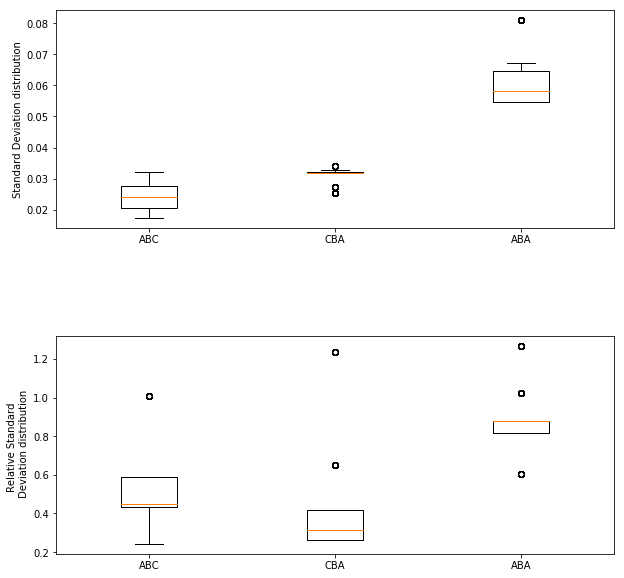

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
ax_hist = fig.add_subplot(2,1,1)
ax_hist.set_ylabel("Standard Deviation distribution")
_ = ax_hist.boxplot(
    [
        fixed_order_serie["Standard Deviation"][fixed_order_serie.corpus == "Fixed"], 
         fixed_order_serie["Standard Deviation"][fixed_order_serie.corpus == "Random"],
         fixed_order_serie["Standard Deviation"][fixed_order_serie.corpus == "Replaced"]
    ]
)
plt.xticks([1,2,3], ["ABC", "CBA", "ABA"])

ax_hist = fig.add_subplot(2,1,2)
ax_hist.set_ylabel("Relative Standard \n Deviation distribution")
_ = ax_hist.boxplot(
    [
        fixed_order_serie["Relative Standard Deviation"][fixed_order_serie.corpus == "Fixed"], 
         fixed_order_serie["Relative Standard Deviation"][fixed_order_serie.corpus == "Random"],
         fixed_order_serie["Relative Standard Deviation"][fixed_order_serie.corpus == "Replaced"]
    ]
)
plt.xticks([1,2,3], ["ABC", "CBA", "ABA"])

plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 10)

**Observations**: 

1. Les entraînements sont globalement stable pour la proximité des paires de mots issus des *topic models* lorsque le corpus reste dans son ordre "original" (ABC) voire dans un order aléatoire (CBA)
2. Le remplacement d'un tiers de corpus aléatoirement par un autre tiers a un grand impact sur ces proximités. On peut y voir un potentiel impact de la duplication (cf. Mimno article) et de l'absence de certaines parties du corpus. L'effet de la duplication peut être facilement prouvable.

## Changements de rangs sur des termes intéressants

Pour chaque mot d'intérêt:

1. On récupère les 100 mots les plus proches dans chaque modèle
2. On ne conserve que les mots présents dans 100% des proximités des modèles
3. On n'observe que 10 de ceux dont la somme des rangs est la plus faible


In [114]:
from collections import defaultdict, Counter
words = ["lascivvs", "mentvla", "virgo", "do", "pvella", "pedico"]
top_ten = defaultdict(Counter)
ranks = defaultdict(lambda : defaultdict(list))
for model in get_models(order=random_order.__name__):
    for word in words:
        top100 = [word for word, score in model.most_similar(positive=[word], topn=100)]
        top_ten[word].update(Counter(top100))
        for rank, neighbor in enumerate(top100):
            ranks[word][neighbor].append(rank)

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


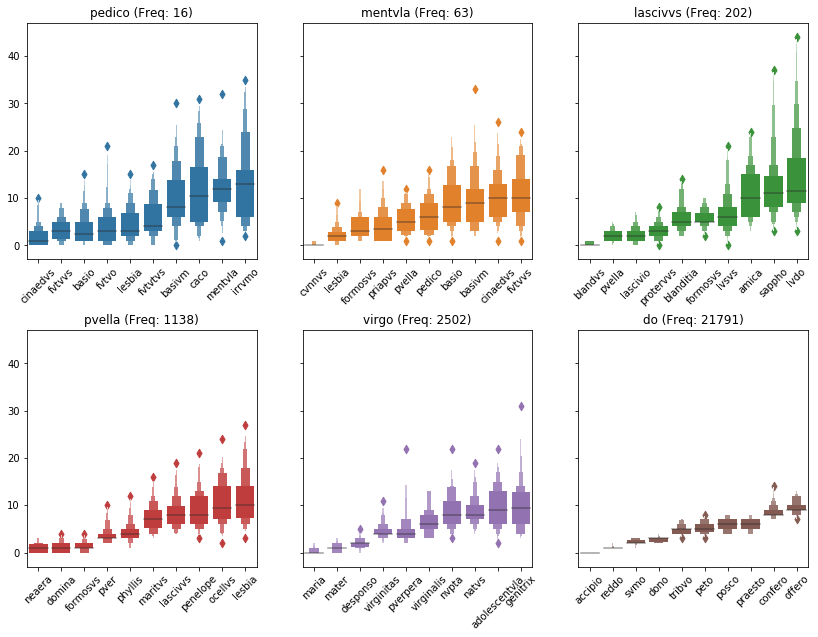

In [115]:
selection = {
    word: sorted(
        [(w, ranks[word][w]) for w, freq in neighbors.items() if freq == 50],
        key=lambda w: sum(ranks[word][w[0]])
    )[:10]
    for word, neighbors in top_ten.items()
}

from pandas import DataFrame, concat

words = sorted([
    (
        cible,
        DataFrame([
            {
                "Cible": cible,
                "Voisin": voisin,
                "Rang": rang
            }
            for voisin, rangs in selection[cible]
            for rang in rangs
        ])
    )
    for cible in selection
], key=lambda x: distribution[x[0]])

from matplotlib import pyplot 

f, axes = plt.subplots(2, 3, figsize=(14, 10), sharey=True)
for ax, (name, word), color in zip(axes.flat, words, sns.color_palette(n_colors=len(words))):
    chart = sns.boxenplot(y="Rang", x="Voisin", data=word, ax=ax, color=color)
    chart.set_title("{} (Freq: {})".format(name, distribution[name]))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    chart.set_xlabel("")
    chart.set_ylabel("")
    
f.subplots_adjust(hspace=0.3)
f.show()